In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import math
import sklearn.preprocessing
from sklearn.preprocessing import StandardScaler
import os
import subprocess as sp

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
np.random.seed(4)

from models import EarlyStopping, GRU
from utilities import get_NSE, MSE, get_colors, print_notes, inverse_transform_sp
from preprocess import load_data, SampleData, init_one_feat

np.random.seed(4)
import pickle

In [2]:
def get_gpu_memory():
    _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]
    ACCEPTABLE_AVAILABLE_MEMORY = 1024
    COMMAND = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = _output_to_list(sp.check_output(COMMAND.split()))[1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values

if torch.cuda.is_available():
    device = torch.device("cuda")
if get_gpu_memory()[0] < 1500 :
    device = torch.device("cpu")
print(device)

# Get colors
colors = get_colors()
colors

cuda


array(['deeppink', 'darkviolet', 'darkgray', 'darkblue', 'darkkhaki',
       'deepskyblue', 'darkslategray', 'darkgreen', 'darkslategrey',
       'darkseagreen', 'darkred', 'darkmagenta', 'darksalmon',
       'darkorchid', 'darkorange', 'darkgoldenrod', 'darkturquoise',
       'darkolivegreen', 'darkcyan', 'darkgrey', 'darkslateblue'],
      dtype='<U14')

In [3]:
output_vars = ['SW_ENDmm']
run_task = 'Train_CMB_inf_SCIF_SW'
# output_vars = ['SNOmm']
# run_task = 'Train_CMB_inf_SCIF_SNO'
# run_task = 'Train_CMB_inf_SCIF_fullStride_SNO'
# output_vars = ['Q_pred_mm']
# run_task = 'Train_CMB_inf_SCIF_SF'
if output_vars[0] == "SW_ENDmm":
    state_input = 'SW_INITmm'
else:
    state_input = output_vars[0]

sim_type = 'full_wsl'
rversion = 'hs32'
#----------------paths-------------------
res_dir = '../results/head_water_SWAT_1000_years/'
exp_dir = res_dir + '{}/rversion_{}/'.format(run_task, rversion)

#--------------------------------------------- load input data -----------------------------
new_data_dir = '../data/1000_year_simulation/'
if sim_type =='full_wsl':
    path = new_data_dir + 'head_water_SWAT_1000_years.csv'
elif sim_type =='nosnow_nofrozen_wsl':
    path = new_data_dir + 'head_water_SWAT_1000_years_no_snow_no_frozen.csv'
elif sim_type =='nosnow_wsl':
    path = new_data_dir + 'head_water_SWAT_1000_years_no_snow.csv'
else:
    raise FileNotFoundError

In [4]:
run_iter = 5
max_iter = run_iter
n_steps = 366
hidden_size = 32
epochs = 500
learning_rate = 0.01
n_classes = len(output_vars)
batch_size = 64
input_size = 8
dropout = 0
nlayers=1
patience = 50

input_vars = ['Date', 'PRECIPmm', 'TMP_MXdgC', 'TMP_MNdgC', 'SOLARMJ/m2', 'WINDM/s', 'RHmd', state_input]
assert(len(input_vars) == input_size)

params = np.load(exp_dir + 'params_ss_{}.npy'.format(n_steps),allow_pickle=True).tolist()
print("The network hypermeters : ")
for k,v in params.items():
    if k != "notes":
        print(k,v)
    if k == "notes":
        print()
        print_notes(params['notes'][0])

The network hypermeters : 
learning_rate 0.01
epochs 500
batch_size 64
hidden_size 32
input_size 8
n_steps 366
dropout 0.0
n_classes 1
num_samples_train 0
shift_train 183
num_samples_valid 0
shift_valid 183
num_samples_test 0
shift_test 183
train_percentage 0.5
valid_percentage 0.1

Goal: Simulate the target variable using state input and 7 weather drivers including Date, PRECIPmm, TMP_MXdgC, TMP_MNdgC, SOLARMJ/m2, WINDM/s, RHmd 
Target variables: SW_ENDmm, SNOmm, Q_pred_mm
Data: 1000 years simulation data
Split data: First 50% of data as the training set, middle 10% of data as the validation set,  last 40% of data as the testing set
Settings:
- Training: Conditional mini-batch (CMB) algorithm
- Model: one layer GRU



In [5]:
df = pd.read_csv(path)
feat, label = load_data(df, output_vars, input_vars, input_size)

# First 50% of data as the training set, middle 10% of data as the validation set, last 40% of data as the testing set.
train_percentage = 0.5
valid_percentage = 0.1
test_percentage = 1 - (train_percentage + valid_percentage)

# Split data
T = feat.shape[0]
train_len = int(T*train_percentage)
valid_len = int(T*valid_percentage)
test_len = T - train_len - valid_len
print(train_len,valid_len,test_len)
train_x = feat[:train_len].copy()
train_y = label[:train_len].copy()
valid_x = feat[train_len:train_len+valid_len].copy()
valid_y = label[train_len:train_len+valid_len].copy()
test_x = feat[train_len+valid_len:].copy()
test_y = label[train_len+valid_len:].copy()

# Normalize data
scaler_x = StandardScaler()
scaler_x.fit(train_x) 
x_train = scaler_x.transform(train_x)
x_valid = scaler_x.transform(valid_x)
x_test = scaler_x.transform(test_x)
scaler_y = StandardScaler()
scaler_y.fit(train_y)
y_train = scaler_y.transform(train_y)
y_valid = scaler_y.transform(valid_y)
y_test = scaler_y.transform(test_y)

# Sample data
## Get indexes
train_idx = np.arange(len(y_train))
valid_idx = np.arange(len(y_valid))
test_idx = np.arange(len(y_test))
## Set stride
num_samples_train = 0
shift_train = int(n_steps/2)
num_samples_valid = 0
shift_valid = int(n_steps/2)
num_samples_test = 0
shift_test = int(n_steps/2)
## Get lists of indexes to sample data. 
train_idx_arr = SampleData(train_idx,n_steps,shift_train,num_samples_train)
num_train_samples = train_idx_arr.shape[0]
valid_idx_arr = SampleData(valid_idx,n_steps,shift_valid,num_samples_valid)
num_valid_samples = valid_idx_arr.shape[0]
test_idx_arr = SampleData(test_idx,n_steps,shift_test,num_samples_test)
num_test_samples = test_idx_arr.shape[0]
## Sample data
x_train_sp_ = x_train[train_idx_arr,:]
y_train_sp_ = y_train[train_idx_arr,:]
m_train_sp_ = y_train_sp_.copy()
m_train_sp_[:,:,:] = 1 # no masking
x_valid_sp_ = x_valid[valid_idx_arr,:]
y_valid_sp_ = y_valid[valid_idx_arr,:]
m_valid_sp_ = y_valid_sp_.copy()
m_valid_sp_[:,:,:] = 1 # no masking
x_test_sp_ = x_test[test_idx_arr,:]
y_test_sp_ = y_test[test_idx_arr,:]
m_test_sp_ = y_test_sp_.copy()
m_test_sp_[:,:,:] = 1 # no masking

# Only keep the initial value of the state feature in each segment for CMB training
x_train_sp_ = init_one_feat(x_train_sp_,-1)
x_valid_sp_ = init_one_feat(x_valid_sp_,-1)
x_test_sp_ = init_one_feat(x_test_sp_,-1)

# Send data to the device
x_train_sp = torch.from_numpy(x_train_sp_).type(torch.float32).to(device)
y_train_sp = torch.from_numpy(y_train_sp_).type(torch.float32).to(device)
m_train_sp = torch.from_numpy(m_train_sp_).type(torch.float32).to(device)

x_valid_sp = torch.from_numpy(x_valid_sp_).type(torch.float32).to(device)
y_valid_sp = torch.from_numpy(y_valid_sp_).type(torch.float32).to(device)
m_valid_sp = torch.from_numpy(m_valid_sp_).type(torch.float32).to(device)

x_test_sp = torch.from_numpy(x_test_sp_).type(torch.float32).to(device)
y_test_sp = torch.from_numpy(y_test_sp_).type(torch.float32).to(device)
m_test_sp = torch.from_numpy(m_test_sp_).type(torch.float32).to(device)

182622 36524 146098
182622
36524
146098


In [6]:
def SCIF_inference_rand_init(model_trained, x_test_sp, scaler_y,rand_init):
    '''
    SCIF use the initial predicted state values make predictions.
    '''
    # Make the first sequence with a random initial.
    x_test_sp = x_test_sp.clone().detach()
    x_test_sp[0,:,-1] = rand_init
    pred = []
    
    hiddens_list = []
    with torch.no_grad():
        # Start making predictions.
        hidden_head = model_trained.init_hidden(1)
        pred_one,hiddens_one = model_trained(torch.unsqueeze(x_test_sp[0],0),hidden_head)
        pred_one = torch.squeeze(pred_one)
        hiddens_one = torch.squeeze(hiddens_one)
        val = pred_one[int(n_steps/2)-1]
        pred.append(pred_one.cpu().numpy())
        hiddens_list.append(hiddens_one.cpu().numpy())

        for i in range(1, len(x_test_sp)):
            x_temp = torch.clone(x_test_sp[i]).detach()
            x_temp[:,-1] = val
            hidden_head = model_trained.init_hidden(1)
            pred_one,hiddens_one = model_trained(torch.unsqueeze(x_temp,0),hidden_head)
            pred_one = torch.squeeze(pred_one)
            hiddens_one = torch.squeeze(hiddens_one)
            val = pred_one[int(n_steps/2)-1]
            pred.append(pred_one.cpu().numpy())
            hiddens_list.append(hiddens_one.cpu().numpy())

    pred = np.squeeze(pred)
    pred_shape = pred.shape
    pred = pred.reshape(-1,n_classes)
    pred = scaler_y.inverse_transform(pred).reshape(pred_shape)
    hiddens_list = np.squeeze(hiddens_list)
    
    return pred, hiddens_list

In [7]:
def get_model(run_iter,path="run_iter_{}_best_model.sav"):
    # Load the best validation model
    path_save = exp_dir+path.format(run_iter)
    # # Load the final epoch model
    # path_save = exp_dir+"final_model.sav"
    checkpoint=torch.load(path_save)
    #output 7 in first module and 3 in second module
    model_trained=GRU(input_size, hidden_size, nlayers, n_classes, dropout)
    model_trained.load_state_dict(checkpoint['model_state_dict'])
    model_trained.to(device)
    epoch = checkpoint['epoch']
    print(epoch)
    model_trained.eval()
    return model_trained


In [8]:
rand_inits = np.asarray([[np.mean(train_y)],[0],[40],[80],[120],[160]])
rand_inits_scaled = torch.squeeze(torch.from_numpy(scaler_y.transform(rand_inits))).type(torch.float32).to(device)
model_trained = get_model(0, "run_iter_{}_best_model.sav")
# The first value is the true value.
# rand_inits_scaled = torch.cat((x_test_sp[0,0,-1].reshape(1),rand_inits_scaled))
pred_test_rand_inits = []
hiddens_test_rand_inits = []

for rand_init in rand_inits_scaled:
    pred_test,hiddens_test = SCIF_inference_rand_init(model_trained, x_test_sp, scaler_y, rand_init)
    pred_test_rand_inits.append(pred_test)
    hiddens_test_rand_inits.append(hiddens_test) 

57


In [9]:
pred_test_init0_iters = []
hiddens_test_init0_iters = []
for itr in range(run_iter):
    model_trained = get_model(itr, "run_iter_{}_best_model.sav")
    pred_test,hiddens_test = SCIF_inference_rand_init(model_trained, x_test_sp, scaler_y, 
                                                          rand_inits_scaled[np.where(np.squeeze(rand_inits) == 0)])
    pred_test_init0_iters.append(pred_test)
    hiddens_test_init0_iters.append(hiddens_test)

57
104
55
104
82


In [10]:
zeroInit = { 'pred_test_itrs': np.squeeze(pred_test_init0_iters),
            'hiddens_test_itrs' : np.squeeze(hiddens_test_init0_iters),
            'rand_init' : 0}
with open(exp_dir + "pred_test_itrs_zeroInit.pickle", 'wb') as f:
    pickle.dump(zeroInit, f, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
pred_test_init0_iters = np.squeeze(pred_test_init0_iters)

In [13]:
'''
This code block inverse_transform predictions to the original scale.
'''
y_sp = np.squeeze(y_test_sp.cpu().numpy())
m_sp = np.squeeze(m_test_sp.cpu().numpy())
y_ori =  y_sp.reshape(-1,n_classes)
y_ori = scaler_y.inverse_transform(y_ori).reshape(y_sp.shape)
idx_arr = test_idx_arr

In [14]:
def get_NSE_itr(y,yhats):
    NSEs = []
    for yhat in yhats:
        NSEs.append(get_NSE(y, yhat))
    return np.asarray(NSEs)

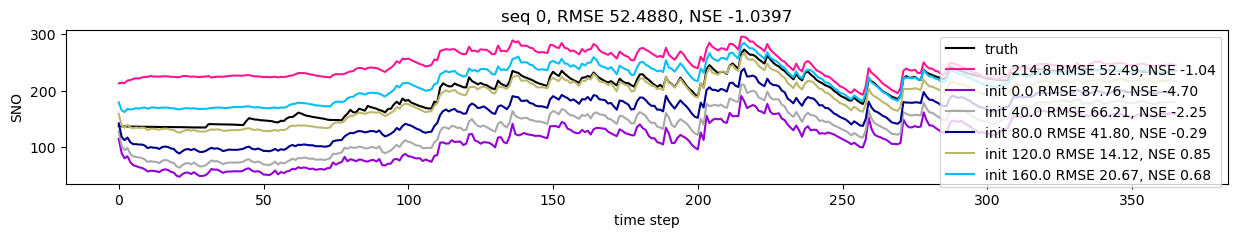

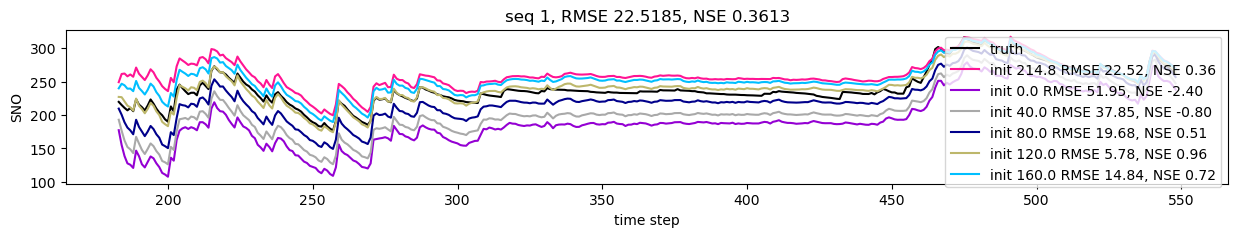

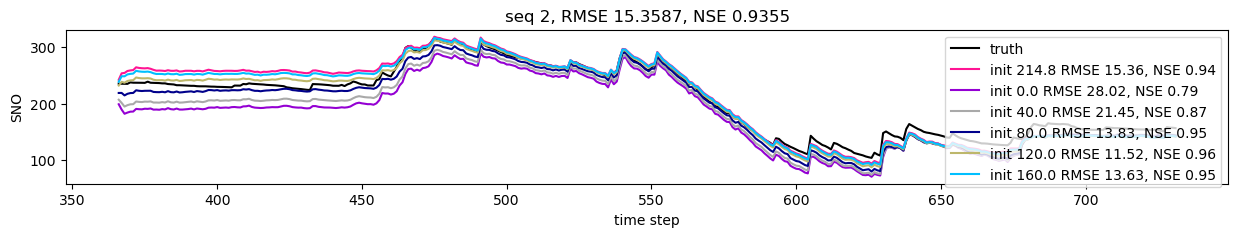

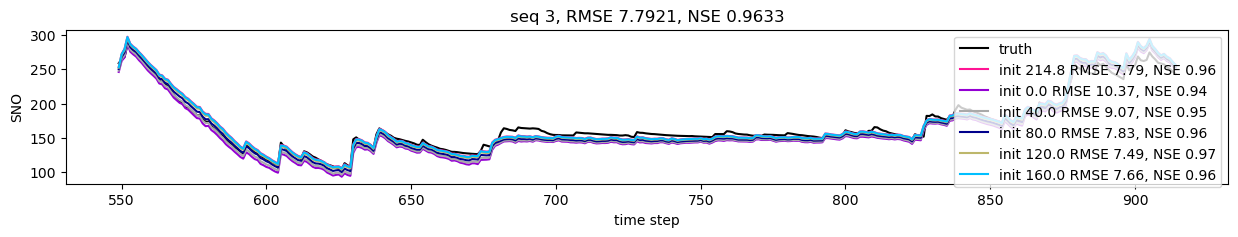

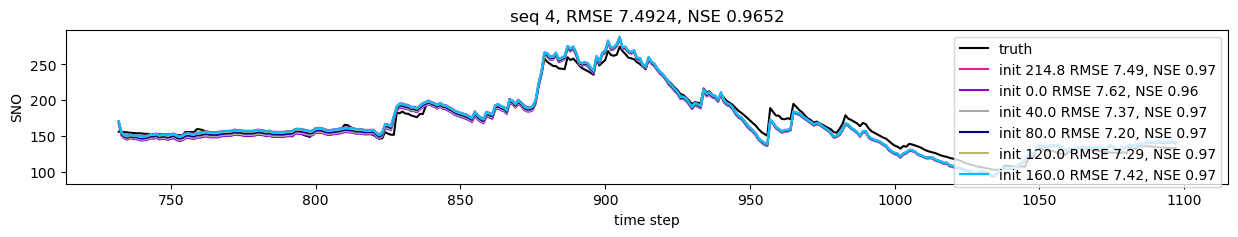

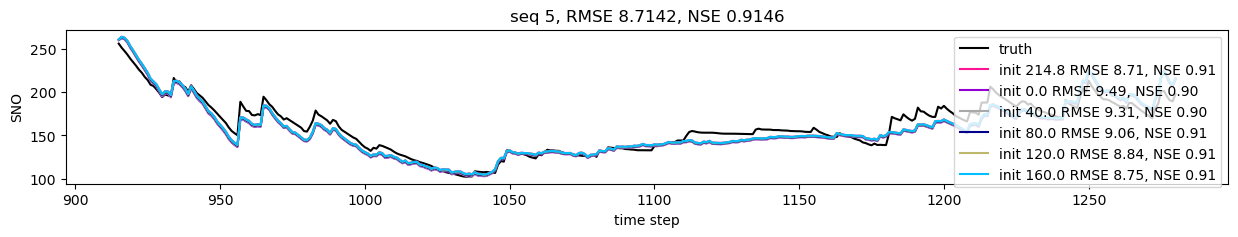

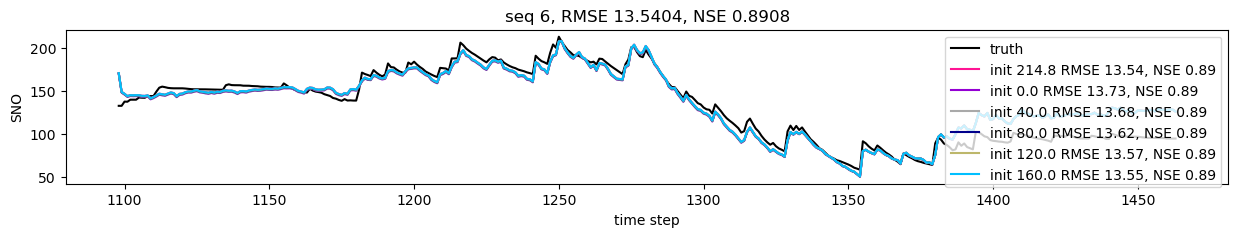

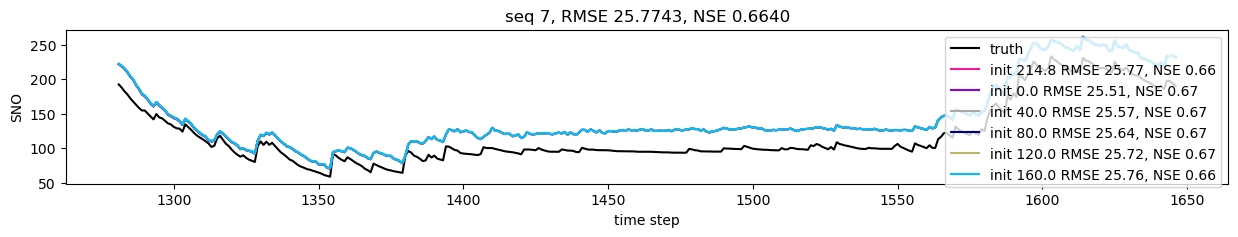

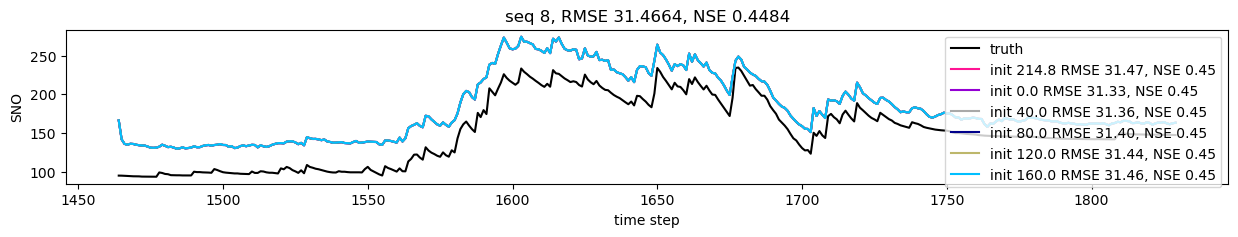

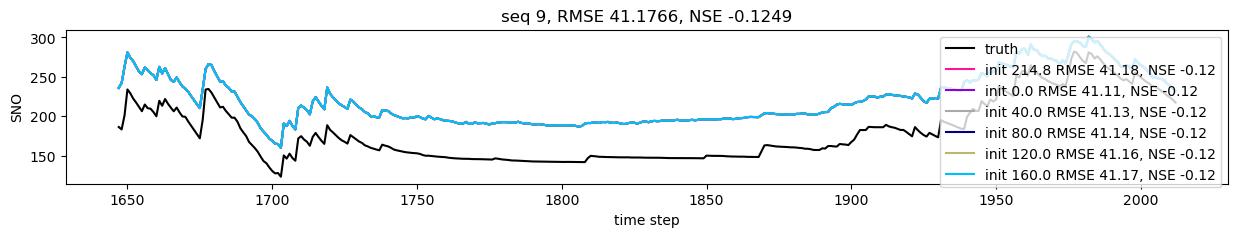

In [15]:
for i in range(0,10):
    ig,ax = plt.subplots(1,1, figsize=(15,2))
    ax.plot(idx_arr[i],y_ori[i],c='black', label='truth')
    for j in range(len(pred_test_rand_inits)):
        label ="init {:.1f} RMSE {:.2f}, NSE {:.2f}".format(rand_inits[j,0],np.sqrt(MSE(y_ori[i], pred_test_rand_inits[j][i], m_sp[i])), get_NSE(y_ori[i], pred_test_rand_inits[j][i]))
        ax.plot(idx_arr[i],pred_test_rand_inits[j][i],c=colors[j], label=label)
    # ax.set_label("time step")
    ax.set_xlabel('time step')
    ax.set_ylabel('SNO')
    plt.title("seq {}, RMSE {:.4f}, NSE {:.4f}".format(i, np.sqrt(MSE(y_ori[i], pred_test_rand_inits[0][i], m_sp[i])), get_NSE(y_ori[i], pred_test_rand_inits[0][i])))
    plt.legend(loc='upper right')
    plt.show()
    plt.close()